## Implementation of an automated trading algorithm

In [390]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The data is made of 2 stocks : Engie, MoneyLion, and the CAC40 index for a daily sample period from 2017-10-24 to 2018-10-23.

In [391]:
fchi = pd.read_csv("^FCHI.csv") #CAC40 index
engi = pd.read_csv("ENGI.PA.csv") #Engie stock
ml = pd.read_csv("ML.PA.csv") #MoneyLion stock

In [392]:
stocks = [fchi, engi, ml]

# Adding a change(% change) column to the data set
for stock in stocks :
    stock["%Change"] = [0] + [
        (stock["Close"][i+1] - stock["Close"][i])/stock["Close"][i]
        for i in range(len(stock["Close"])-1)
        ]

#### Now we implement a moving average average algorithm :
The moving average at time t is computed by averaging the values of the stock for the period of time from $ t-\delta $ to $ t $.

$ MA_{\delta}(stock, t) = \frac{1}{\delta} \sum_{i=t-\delta}^{t} stock(i) $


In [393]:
# Implementation of moving average
## This implementation can be improved by using a rolling mean

def MA(data, sample_period):
    N = sample_period
    ma_ = []
    for i in range(N-1):
        ma_.append(np.nan) # The MA is only defined for periods > sample_period
    for i in range(N-1, len(data)):
        ma_.append(
            sum(data[i-(N-1):i+1])/N 
        )
    return ma_

In [394]:
# MA50s
fchi_ma_50 = pd.Series(MA(fchi["Close"], 50)).dropna()
engi_ma_50 = pd.Series(MA(engi["Close"], 50)).dropna()
ml_ma_50 = pd.Series(MA(ml["Close"], 50)).dropna()

# MA20s
fchi_ma_20 = pd.Series(MA(fchi["Close"], 20)).dropna()
engi_ma_20 = pd.Series(MA(engi["Close"], 20)).dropna()
ml_ma_20 = pd.Series(MA(ml["Close"], 20)).dropna()

# MA10s
fchi_ma_10 = pd.Series(MA(fchi["Close"], 10)).dropna()
engi_ma_10 = pd.Series(MA(engi["Close"], 10)).dropna()
ml_ma_10 = pd.Series(MA(ml["Close"], 10)).dropna()

Since the implementation of an anterior moving average enforces us to drop the first value, the rest of the work will be done for the same sample period but delayed for 20 days.

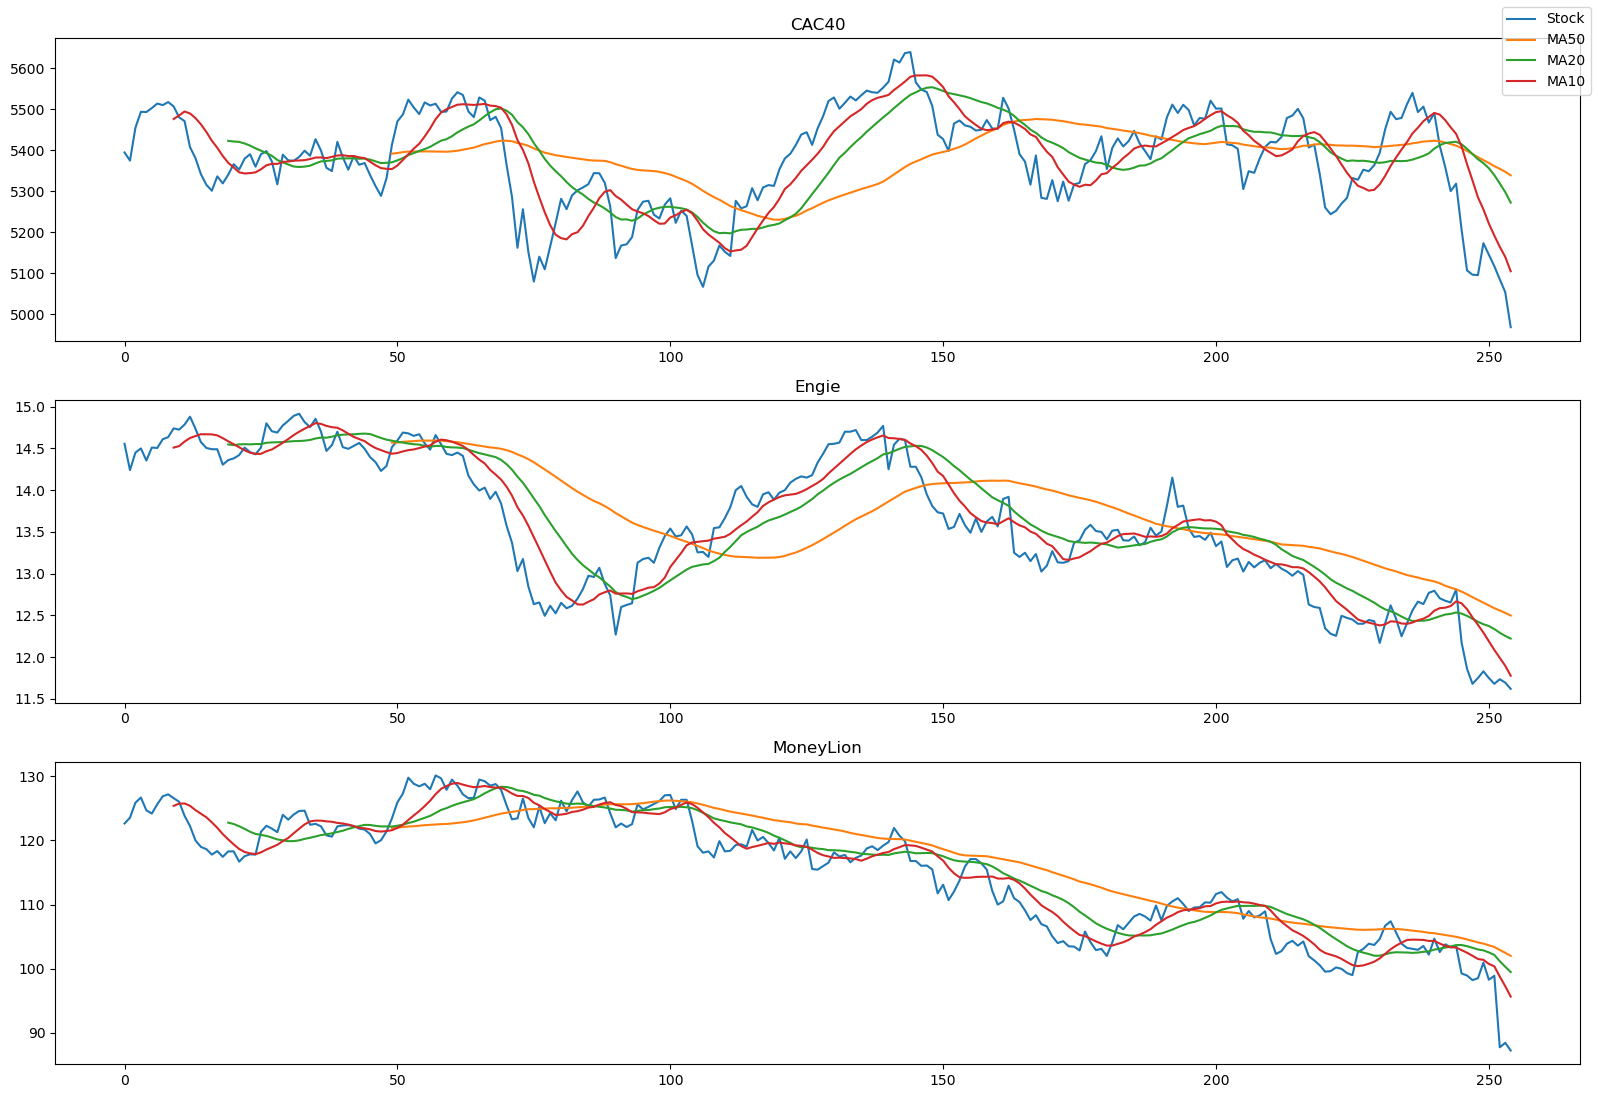

In [395]:
fig, ax  = plt.subplots(3, 1, figsize=(16, 11))

ax[0].plot(fchi["Close"], label="Stock")
ax[0].plot(fchi_ma_50, label="MA50")
ax[0].plot(fchi_ma_20, label="MA20")
ax[0].plot(fchi_ma_10, label="MA10")
ax[0].set_title("CAC40")

ax[1].plot(engi["Close"])
ax[1].plot(engi_ma_50)
ax[1].plot(engi_ma_20)
ax[1].plot(engi_ma_10)
ax[1].set_title("Engie")

ax[2].plot(ml["Close"])
ax[2].plot(ml_ma_50)
ax[2].plot(ml_ma_20)
ax[2].plot(ml_ma_10)
ax[2].set_title("MoneyLion")

fig.legend()
fig.tight_layout()
plt.show()

#### MA cross Trading strategy :

While the Moving averages convey a kind of momentum of the stock by using its movements in the past, a good intuition could be that the MA10 rallies better with stock price changes and that when it crosses with a larger period moving average, it is the sign of the stock moving upward or downward.
Of course this intuition becomes caduque when the stock price fluctuates quickly and with high amplitudes. Which is not the historical case for the stocks we are analysing.

We the define two strategies to profit from the stock movements. If the price rises we buy and we sell immediately when it goes down again, and to profit from its fall we short the stock and cover when it rallies. The rest of the time we do nothing. Each time we buy or short the volume corresponding to the value of our porfolio. 

The "price rises" and "price falls" information are given by the crossing of two moving averages for different windows.







In [396]:
# Defining BUY and SELL signals

def signal(ma_10_t0, ma_10_t1, ma_20_t0, ma_20_t1, position_t0, sig_type):
    delta_ma_t0 = ma_10_t0 - ma_20_t0 # Difference of MAs at time t0
    delta_ma_t1 = ma_10_t1 - ma_20_t1 # Difference of MAs at time t1
    action = {
        "position":"",
        "signal":""
    }

    #Signals intersects if the difference of MAs changes sign from t0 to t1
    if delta_ma_t0*delta_ma_t1 < 0:
    # Signal for buy sell strategy
        if sig_type == "buy-sell":
            if ma_10_t1 > ma_20_t1:
                if position_t0 == "Close":
                    action["position"] = "Open"
                    action["signal"] = "BUY"
                if position_t0 == "Open":
                    action["position"] = position_t0
                    action["signal"] = "DO NOTHING"
            elif ma_10_t1 < ma_20_t1:
                if position_t0 == "Close":
                    action["position"] = position_t0
                    action["signal"] = "DO NOTHING"
                if position_t0 == "Open":
                    action["position"] = "Close"
                    action["signal"] = "SELL"
            else:
                action["position"] = position_t0
                action["signal"] = "DO NOTHING"
            
    # Signal for short cover strategy
        if sig_type == "short-cover":
            if ma_10_t1 > ma_20_t1:
                if position_t0 == "Close":
                    action["position"] = position_t0
                    action["signal"] = "DO NOTHING"
                if position_t0 == "Open":
                    action["position"] = "Close"
                    action["signal"] = "COVER"
            elif ma_10_t1 < ma_20_t1:
                if position_t0 == "Close":
                    action["position"] = "Open"
                    action["signal"] = "SHORT"
                if position_t0 == "Open":
                    action["position"] = position_t0
                    action["signal"] = "DO NOTHING"
            else:
                action["position"] = position_t0
                action["signal"] = "DO NOTHING"
    else:
        action["position"] = position_t0
        action["signal"] = "DO NOTHING"

    return action

In [397]:
# Creating a portfolio with Engie stock and evaluating the return

# Adding moving averages to the portfolio
portfolio = engi
portfolio["MA_10"] = MA(engi["Close"], 10)
portfolio["MA_20"] = MA(engi["Close"], 20)
portfolio = portfolio.dropna()
portfolio.reset_index(inplace=True)
N = len(portfolio["MA_20"])

# Adding signal and diverse positions
portfolio["Position_1"] = ["Close"] + [np.nan for i in range(N-1)]
portfolio["Position_2"] = ["Close"] + [np.nan for i in range(N-1)]
portfolio["Signal_1"] = ["DO NOTHING"] + [np.nan for i in range(N-1)]
portfolio["Signal_2"] = ["DO NOTHING"] + [np.nan for i in range(N-1)]

for i in range(1, N):
    action = signal(
        ma_10_t0=portfolio["MA_10"][i-1],
        ma_10_t1=portfolio["MA_10"][i],
        ma_20_t0=portfolio["MA_20"][i-1],
        ma_20_t1=portfolio["MA_20"][i],
        position_t0=portfolio["Position_1"][i-1],
        sig_type="buy-sell"
    )
    portfolio.loc[i, "Position_1"] = action["position"]
    portfolio.loc[i, "Signal_1"] = action["signal"]

for i in range(1, N):
    action = signal(
        ma_10_t0=portfolio["MA_10"][i-1],
        ma_10_t1=portfolio["MA_10"][i],
        ma_20_t0=portfolio["MA_20"][i-1],
        ma_20_t1=portfolio["MA_20"][i],
        position_t0=portfolio["Position_2"][i-1],
        sig_type="short-cover"
    )
    portfolio.loc[i, "Position_2"] = action["position"]
    portfolio.loc[i, "Signal_2"] = action["signal"]
    

C:\Users\Main_YnFb\AppData\Local\Temp\ipykernel_14152\3025557184.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio["Position_1"] = ["Close"] + [np.nan for i in range(N-1)]
C:\Users\Main_YnFb\AppData\Local\Temp\ipykernel_14152\3025557184.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio["Position_2"] = ["Close"] + [np.nan for i in range(N-1)]
C:\Users\Main_YnFb\AppData\Local\Temp\ipykernel_14152\3025557184.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [399]:
portfolio.loc[:, "Return_1"] = np.nan
portfolio.loc[:, "Return_2"] = np.nan
portfolio.loc[0, "Return_1"] = 1
portfolio.loc[0, "Return_2"] = 1

C:\Users\Main_YnFb\AppData\Local\Temp\ipykernel_14152\223162908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio.loc[:, "Return_1"] = np.nan
C:\Users\Main_YnFb\AppData\Local\Temp\ipykernel_14152\223162908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio.loc[:, "Return_2"] = np.nan


#### Computation of returns :

Let $ p_t $ the value of an asset at time t. We define $ \alpha_t = \frac{p_t-p_{t-1}}{p_{t-1}} $, the percent change in price of the asset.

The value of our portfolio containing this asset at time t while using this trading strategy is  $ V_t = (1+\alpha_t)V_{t-1} = V_0\prod_{i=0}^{t} (1+\alpha_i) $ with $ V_0 = 1 $ (value per euro).

Note : 
* On short/cover operations, $ \alpha_t $ is inverted since we lose money as the price goes up.
* $ V_t = 1 $ means we have made no improvement,$ V_t = 1+\alpha $ means $ \alpha $ is our return.

Proof : With $ V_0 = 1 $, our return at t is $ \frac{V_t-V_0}{V_0} = V_t-V_0 = V_t-1 = \alpha $



In [433]:
# Computing the returns of our trading strategy

for i in range(1, N):
    ## Return for buy-sell strategy
    if portfolio["Position_1"][i] == "Open":
        if portfolio["Signal_1"][i] == "BUY":
            Buy_price = portfolio["Close"][i]
            alpha = (portfolio["Close"][i]-portfolio["Close"][i-1])/Buy_price
            portfolio.loc[i, "Return_1"] = (1+alpha)*portfolio["Return_1"][i-1]
        if portfolio["Signal_1"][i] == "DO NOTHING":
            alpha = (portfolio["Close"][i]-portfolio["Close"][i-1])/portfolio["Close"][i-1]
            portfolio.loc[i, "Return_1"] = (1+alpha)*portfolio["Return_1"][i-1]

    if portfolio["Position_1"][i] == "Close":
        if portfolio["Signal_1"][i] == "SELL":
            alpha = (portfolio["Close"][i]-portfolio["Close"][i-1])/portfolio["Close"][i-1]
            portfolio.loc[i, "Return_1"] = (1+alpha)*portfolio["Return_1"][i-1]
        if portfolio["Signal_1"][i] == "DO NOTHING":
            portfolio.loc[i, "Return_1"] = portfolio["Return_1"][i-1]
        
    ## Return for short-cover strategy
    if portfolio["Position_2"][i] == "Open":
        if portfolio["Signal_2"][i] == "SHORT":
            Short_price = portfolio["Close"][i]
            alpha = (Short_price-portfolio["Close"][i])/Short_price 
            portfolio.loc[i, "Return_2"] = (1+alpha)*portfolio["Return_2"][i-1]
        if portfolio["Signal_2"][i] == "DO NOTHING":
            alpha = (portfolio["Close"][i-1]-portfolio["Close"][i])/portfolio["Close"][i-1]
            portfolio.loc[i, "Return_2"] = (1+alpha)*portfolio["Return_2"][i-1]

    if portfolio["Position_2"][i] == "Close":
        if portfolio["Signal_2"][i] == "COVER": 
            alpha = (portfolio["Close"][i-1]-portfolio["Close"][i])/portfolio["Close"][i-1]
            portfolio.loc[i, "Return_2"] = (1+alpha)*portfolio["Return_2"][i-1]
        if portfolio["Signal_2"][i] == "DO NOTHING":
            portfolio.loc[i, "Return_2"] = portfolio["Return_2"][i-1]

# Averaging the returns to combine both strategies
portfolio["Return"] = (portfolio["Return_1"] + portfolio["Return_2"])/2

# Adding a log-return column
portfolio["log-Return"] = np.log(portfolio["Return"])

C:\Users\Main_YnFb\AppData\Local\Temp\ipykernel_14152\2304136664.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio["Return"] = (portfolio["Return_1"] + portfolio["Return_2"])/2
C:\Users\Main_YnFb\AppData\Local\Temp\ipykernel_14152\2304136664.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio["log-Return"] = np.log(portfolio["Return"])


In [434]:
portfolio

,index,Date,Open,High,Low,Close,Adj Close,Volume,%Change,MA_10,MA_20,Position_1,Position_2,Signal_1,Signal_2,Return_1,Return_2,Return,log-Return
0,19,2017-11-20,14.305,14.450,14.290,14.360,13.610926,4128587,0.003845,14.5850,14.54750,Close,Close,DO NOTHING,DO NOTHING,1.000000,1.000000,1.000000,0.000000
1,20,2017-11-21,14.370,14.515,14.330,14.380,13.629884,4169128,0.001393,14.5505,14.53875,Close,Close,DO NOTHING,DO NOTHING,1.000000,1.000000,1.000000,0.000000
2,21,2017-11-22,14.405,14.620,14.390,14.420,13.667796,3812116,0.002782,14.5140,14.54775,Close,Open,DO NOTHING,SHORT,1.000000,1.000000,1.000000,0.000000
3,22,2017-11-23,14.375,14.585,14.345,14.510,13.753101,3622878,0.006241,14.4770,14.55075,Close,Open,DO NOTHING,DO NOTHING,1.000000,0.993759,0.996879,-0.003126
4,23,2017-11-24,14.515,14.595,14.455,14.455,13.700971,3355090,-0.003790,14.4490,14.54850,Close,Open,DO NOTHING,DO NOTHING,1.000000,0.997526,0.998763,-0.001238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,250,2018-10-17,11.895,11.980,11.715,11.750,11.750000,6456946,-0.006762,12.1890,12.37275,Close,Open,DO NOTHING,DO NOTHING,1.009115,1.187120,1.098117,0.093597
232,251,2018-10-18,11.775,11.880,11.660,11.680,11.680000,7325631,-0.005957,12.0865,12.33650,Close,Open,DO NOTHING,DO NOTHING,1.009115,1.194192,1.101653,0.096812
233,252,2018-10-19,11.720,11.810,11.690,11.735,11.735000,10350461,0.004709,11.9925,12.29225,Close,Open,DO NOTHING,DO NOTHING,1.009115,1.188568,1.098842,0.094257
234,253,2018-10-22,11.820,11.915,11.695,11.695,11.695000,4808260,-0.003409,11.8965,12.25400,Close,Open,DO NOTHING,DO NOTHING,1.009115,1.192620,1.100867,0.096098


In [435]:
# Computing returns and log returns of CAC40
cac40 = fchi.drop([i for i in range(19)], axis=0)
cac40["Return"] = [1] + [np.nan for i in range(len(cac40["Close"])-1)]
cac40.reset_index(inplace=True)

Start_value = cac40["Close"][0]
for i in range(1, len(cac40["Close"])):
    alpha = (cac40["Close"][i]-cac40["Close"][i-1])/cac40["Close"][i-1]
    cac40.loc[i, "Return"] = (1+alpha)*cac40.loc[i-1,"Return"]

cac40["log-Return"] = np.log(cac40["Return"])
cac40

,index,Date,Open,High,Low,Close,Adj Close,Volume,%Change,Return,log-Return
0,19,2017-11-20,5311.279785,5348.149902,5302.850098,5340.450195,5340.450195,66757000,0.004001,1.000000,0.000000
1,20,2017-11-21,5335.839844,5385.859863,5326.859863,5366.149902,5366.149902,74777300,0.004812,1.004812,0.004801
2,21,2017-11-22,5364.609863,5391.009766,5352.759766,5352.759766,5352.759766,67526600,-0.002495,1.002305,0.002302
3,22,2017-11-23,5339.759766,5391.890137,5330.319824,5379.540039,5379.540039,55368500,0.005003,1.007320,0.007293
4,23,2017-11-24,5374.399902,5419.879883,5374.399902,5390.459961,5390.459961,54357200,0.002030,1.009364,0.009321
...,...,...,...,...,...,...,...,...,...,...,...
231,250,2018-10-17,5187.109863,5205.379883,5117.229980,5144.950195,5144.950195,90604000,-0.005432,0.963393,-0.037294
232,251,2018-10-18,5150.229980,5175.589844,5115.310059,5116.790039,5116.790039,99240000,-0.005473,0.958120,-0.042783
233,252,2018-10-19,5119.640137,5133.589844,5057.450195,5084.660156,5084.660156,130238900,-0.006279,0.952103,-0.049082
234,253,2018-10-22,5130.290039,5135.689941,5052.240234,5053.310059,5053.310059,74610400,-0.006166,0.946233,-0.055266


#### Returns of the portfolio traded with our strategy :

From the graphs below, We can see that our trading strategy works fine. We are able to beat the market by 10% at the end of the sample period. And by the day 75, we are constantly over the the market in performance.

The fact that we can beat the market is simply because the efficient market hypothesis is not true in practice, at least in this market.
We used past data (moving averages) to forecast momentum of stocks and hence profit from it. Even if markets rallies with expectation for the future of people trading on it, the implied movement of the market is not done instantly and one can profit from this.

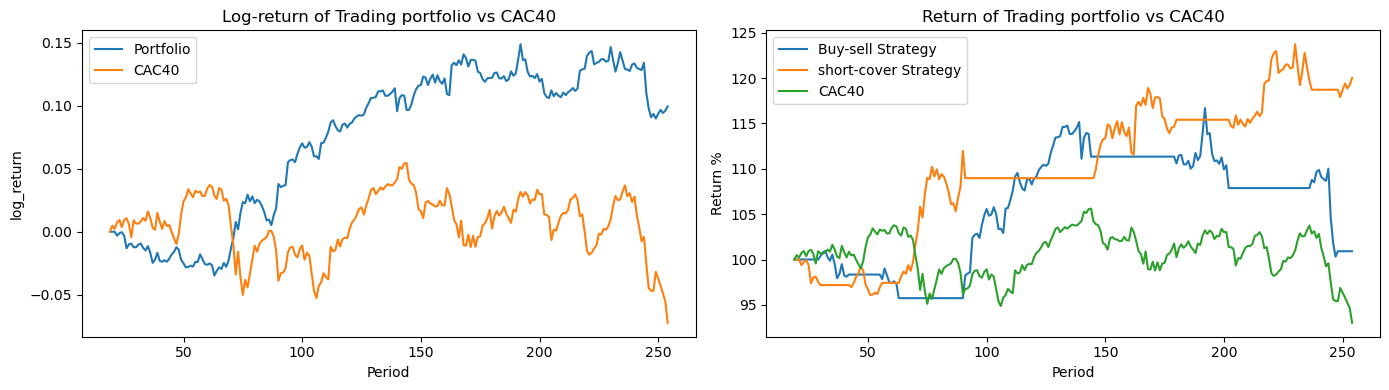

In [438]:

fig, ax  = plt.subplots(1,2,figsize=(14, 4))
ax[0].plot(portfolio["index"], portfolio["log-Return"], label="Portfolio")
ax[0].plot(cac40["index"], cac40["log-Return"], label="CAC40")
ax[0].set_xlabel("Period")
ax[0].set_ylabel("log_return")
ax[0].legend()
ax[0].set_title("Log-return of Trading portfolio vs CAC40")

ax[1].plot(portfolio["index"], 100*portfolio["Return_1"], label="Buy-sell Strategy")
ax[1].plot(portfolio["index"], 100*portfolio["Return_2"], label="short-cover Strategy")
ax[1].plot(cac40["index"], 100*cac40["Return"], label="CAC40")
ax[1].set_xlabel("Period")
ax[1].set_ylabel("Return %")
ax[1].legend()
ax[1].set_title("Return of Trading portfolio vs CAC40")
fig.tight_layout()